# Case Data Master Cientista de Dados

### Tarefa A
a) Um falso positivo ocorre quando classificamos um cliente como insatisfeito, mas ela não se comporta como tal. Neste caso, o custo de preparar e executar uma ação de retenção é um valor fixo de RS10 por cliente. Nada é ganho pois a ação de retenção não é capaz de mudar o comportamento do cliente. Um falso negativo ocorre quando um cliente é previsto como satisfeito, mas na verdade ele estava insatisfeito. Neste caso, nenhum dinheiro foi gasto e nada foi ganho. Um verdadeiro positivo é um cliente que estava insatisfeito e foi alvo de uma ação de retenção. O benefício neste caso é o lucro da ação (RS100) menos os custos relacionados à ação de retenção ($10). Por fim, um verdadeiro negativo é um cliente insatisfeito e que não é alvo de nenhuma ação. O benefício neste caso é zero, isto é, nenhum custo, mas nenhum lucro.

A primeira tarefa deste case é maximizar o lucro esperado por cliente considerando o contexto descrito no parágrafo acima.


### Tarefa B
b. A segunda tarefa consiste em dar uma nota de 1 a 5 para cada cliente da base teste, respeitando a variável ‘TARGET’, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito. Ao dar essa nota deve-se ter em mente que somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado por cliente (usando os mesmos valores da primeira questão).

### Tarefa C
c. Todo conjunto de dados é passível de ser dividido em grupos coesos, conhecidos como agrupamentos naturais. A terceira tarefa é encontrar os três grupos naturais que possuem os maiores lucros esperados por cliente (usando os mesmos valores da primeira questão).

# Instalações & Importações

In [43]:
# ## Instalação de Bibliotecas
# !pip install numpy
# !pip install seaborn
# !pip install scikit-learn
# !pip install scipy
# !pip install factor_analyzer
# !pip install matplotlib
# !pip install catboost
# !pip install graphviz
# !pip install plotly
# !pip install six
# !pip install shap-selection
# !pip install shap-selection

In [ ]:
# Bibliotecas Basicás
import numpy as np 
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt 
import sklearn

## Validação Cruzada e Pipeline
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

## Métricas de Validação
from sklearn.metrics import average_precision_score, roc_auc_score 
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

## Pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modelos
import xgboost 
from xgboost import XGBClassifier
from  sklearn.linear_model import LogisticRegression
from  sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Funções

## Funções de Relatório e Pré-Processamento

In [ ]:
def calcula_prevalencia(y_actual):
    '''
    Calcula e exibe a prevalência da classe positiva em um conjunto de rótulos reais.
    '''
    print(f'Prevalência da classe não nula (1): {sum(y_actual) * 100/ len(y_actual):.3f}%')


def calcula_valores_validos(df):
    '''
    Calcula e exibe a porcentagem de valores nulos ou faltantes em cada coluna do DataFrame apenas se existirem.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado. 
    '''
    valores_exibidos = 0
    for col in df.columns:
        soma_nulos = sum(df[col].isnull() | df[col].isna())
        if soma_nulos > 0 :
            print(f'Valores Nulos em {col}: {soma_nulos * 100/ len(df[col]):.3f}%')
            valores_exibidos += 1
    if valores_exibidos == 0:
        print('Nenhum valor nulo ou faltante encontrado no DataFrame.')


def verifica_balanceamento(df, coluna_alvo):
    '''
    Verifica o balanceamento das classes em uma coluna alvo de um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    coluna_alvo (str): O nome da coluna alvo que contém as classes.
    '''
    contagem_classes = df[coluna_alvo].value_counts()
    proporcao_classes = df[coluna_alvo].value_counts(normalize=True) * 100
    balanceamento = pd.DataFrame({'Contagem': contagem_classes, 'Proporção (%)': np.round(proporcao_classes, 2)})
    print(balanceamento)


def verifica_coluna_constante(df):
    '''
    Verifica se há colunas constantes (com o mesmo valor em todas as linhas) em um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    colunas_constantes = [col for col in df.columns if df[col].nunique() == 1]
    if colunas_constantes:
        print(f'Colunas constantes encontradas: {colunas_constantes}')
    else:
        print('Nenhuma coluna constante encontrada.')


def relatorio(df: pd.DataFrame) -> None:
    """Gera um breve relatório exploratório do DataFrame"""


    print("=" * 70)
    print(f"Número de Colunas: {df.shape[1]:,}")
    print(f"Número de Linhas: {df.shape[0]:,}")
    print("=" * 70)

    # Linhas duplicadas (ignorando ID)
    dup_mask = df.drop(columns=['ID','TARGET'], errors='ignore').duplicated(keep='first')
    print(f"Número de Linhas Duplicadas: {dup_mask.sum():,}")

    # Colunas constantes
    const_cols = [
        c for c in df.columns
        if c != 'ID' and df[c].nunique(dropna=False) == 1
    ]
    print(f"Número de Colunas Constantes: {len(const_cols):,}")

    # Colunas idênticas (Aprofundar o Conceitual)
    col_hashes = df.apply(lambda col: hash(tuple(col)), axis=0)
    num_identicas = col_hashes.duplicated().sum()
    print(f"Número de Colunas Idênticas: {num_identicas:,}")

    print("=" * 70)

    # Valores nulos
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0].sort_values(ascending=False)
    print(f"Colunas com Valores Nulos: {len(nulls):,}")

    print("=" * 70)

    # Distribuição da variável TARGET
    if 'TARGET' in df.columns:
        target_0 = (df['TARGET'] == 0).sum()
        target_1 = (df['TARGET'] == 1).sum()
        total = len(df)

        print(f"TARGET = 0 (Insatisfeitos): {target_0:,} ({target_0 / total:.1%})")
        print(f"TARGET = 1 (Satisfeitos): {target_1:,} ({target_1 / total:.1%})")
        print(f"Total de clientes: {total:,}")
    else:
        print("Coluna TARGET não encontrada.")

    print("=" * 70)


## Funções de Cross-Validation Personalizadas

In [ ]:
def threshold_otimizado_f1(y_true, y_prob, n_thresholds=100):
    """
    Encontra o threshold que maximiza o F1-score.
    """
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    best_f1 = -1
    best_threshold = 0.5

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


def validacao_cruzada_f1(
    modelo, 
    X, 
    y,
    metric,
    oversampler=None, 
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada com threshold otimizado para F1-score.
    """
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    scores = []
    thresholds_otimos = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo 
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Probabilidade da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # Threshold ótimo + F1
        best_threshold, best_f1 = threshold_otimizado_f1(y_test, y_prob)

        scores.append(best_f1)
        thresholds_otimos.append(best_threshold)

        print(
            f"Fold {fold}: "
            f"F1 = {best_f1:.4f} | "
            f"Threshold ótimo = {best_threshold:.2f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"F1 médio: {np.mean(scores):.4f}")
    print(f"Desvio padrão F1: {np.std(scores):.4f}")
    print(f"Threshold médio: {np.mean(thresholds_otimos):.2f}")

    return {
        "f1_scores": scores,
        "thresholds": thresholds_otimos
    }


def validacao_cruzada_prauc(
    modelo, 
    X, 
    y,
    oversampler=None, 
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada usando PR-AUC (Average Precision).
    Avalia ranking, não threshold.
    """

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    pr_auc_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Score contínuo da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # PR-AUC (Average Precision)
        pr_auc = average_precision_score(y_test, y_prob)
        pr_auc_scores.append(pr_auc)

        print(
            f"Fold {fold}: "
            f"PR-AUC = {pr_auc:.4f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"PR-AUC médio: {np.mean(pr_auc_scores):.4f}")
    print(f"Desvio padrão PR-AUC: {np.std(pr_auc_scores):.4f}")

    return {
        "pr_auc_scores": pr_auc_scores
    }



## Funções de Pipeline

In [ ]:
class PipeSteps(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

class SelecionaColunas(PipeSteps):
    def transform(self, X):
        X = X.copy()
        return X[self.columns]

class PadronizaDados(PipeSteps):
    def fit(self, X, y = None ):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y =None):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

## Importação de Arquivos

In [46]:
df_train = pd.read_csv("data/processed/train.csv")
df_test = pd.read_csv("data/processed/test.csv")

# Análise Exploratória

In [96]:
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [48]:
df_test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


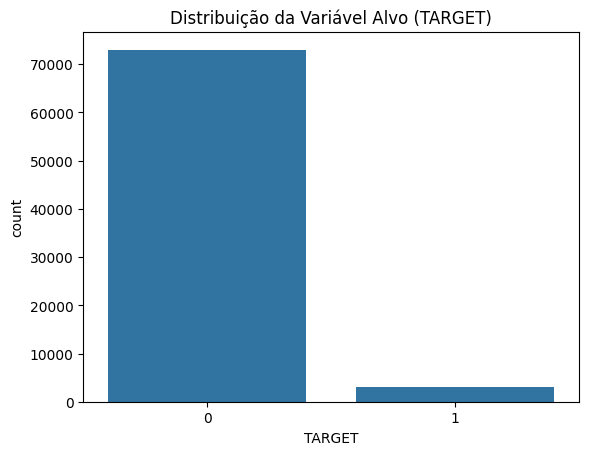

In [50]:
sns.countplot(x='TARGET', data=df_train)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.show()

In [51]:
verifica_balanceamento(df_train,'TARGET')
calcula_valores_validos(df_train)
verifica_coluna_constante(df_train)

        Contagem  Proporção (%)
TARGET                         
0          73012          96.04
1           3008           3.96
Nenhum valor nulo ou faltante encontrado no DataFrame.
Colunas constantes encontradas: ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [52]:
relatorio(df_train)

Número de Colunas: 371
Número de Linhas: 76,020
Número de Linhas Duplicadas: 4,940
Número de Colunas Constantes: 34
Número de Colunas Idênticas: 62
Colunas com Valores Nulos: 0
TARGET = 0 (Insatisfeitos): 73,012 (96.0%)
TARGET = 1 (Satisfeitos): 3,008 (4.0%)
Total de clientes: 76,020


In [53]:
# Colunas Categóricas
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

print('Colunas categóricas:', list(cat_cols))
print('Qtd:', len(cat_cols))

# Possíveis colunas categóricas numéricas ou com Baixo Número valores únicos
candidate_cat = [
    col for col in df_train.select_dtypes(include=['int', 'int64', 'float']).columns
    if df_train[col].nunique() <= 10
]

# Serão usadas para análises futuras
print('Possíveis categóricas numéricas:', len(candidate_cat))

Colunas categóricas: []
Qtd: 0
Possíveis categóricas numéricas: 239


# Separação em Treino e Validação

In [54]:
# Lista dos atributos que serão utilizados como entrada (Diferentes da classe alvo, ID e não constantes)
atributos = [x for x in df_train.columns if 
             (df_train[f'{x}'].nunique() > 1 
              and x not in ('Class', 'TARGET'))]

In [55]:
X = df_train[atributos]
y = df_train['TARGET']
X_treino, X_teste, y_treino, y_teste = train_test_split(
                                                    X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size = 0.30, 
                                                    random_state = 42)

In [56]:
calcula_prevalencia(y_treino)

Prevalência da classe não nula (1): 3.958%


In [57]:
calcula_prevalencia(y_teste)

Prevalência da classe não nula (1): 3.955%


# Modelos Base

In [ ]:

pipe_prepropcessamento = Pipeline([
    ('standard_scaling', PadronizaDados(atributos))
])

# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('preprocessing', pipe_prepropcessamento),
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X,
        y,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)


Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.5964
Desvio ROC_AUC: 0.0142
PR_AUC médio : 0.0550
Desvio PR_AUC: 0.0026
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.8096
Desvio ROC_AUC: 0.0094
PR_AUC médio : 0.1512
Desvio PR_AUC: 0.0072
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7601
Desvio ROC_AUC: 0.0347
PR_AUC médio : 0.1247
Desvio PR_AUC: 0.0116
--------------------------------------------------


In [ ]:
# Supondo que seu pipeline seja algo assim:
from xgboost import XGBClassifier
import pandas as pd

# Modelo já treinado
xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

# Treine no seu dataset completo
xgb.fit(X, y)

# Extrair importância
importances = xgb.feature_importances_

# Criar DataFrame para ver mais fácil
df_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(df_importances.head(20))  # Top 20 variáveis


# Seleção de Features

## Análise de Corelação entre as Variáveis

In [64]:
# Cálculo da matriz de correlação
corr_matrix = X.corr()

# Mantém apenas correlações fortes (maior que 0.5 ou menor que -0.5), 
# excluindo a diagonal principal
strong_corr = corr_matrix.where(
    (np.abs(corr_matrix) > 0.5) & (np.abs(corr_matrix) < 1.0)
)

# Remoção de linhas e colunas que são completamente NaN
strong_corr_clean = (
    strong_corr
    .dropna(how='all', axis=1)
    .dropna(how='all', axis=0)
)

# Máscara para ocultar a parte superior da matriz de correlação
mask_upper = np.triu(
    np.ones_like(strong_corr_clean, dtype=bool),
    k=1
)

# Aplicação da máscara
strong_corr_final = strong_corr_clean.mask(mask_upper)

# Conversão para DataFrame longo
corr_df = (
    strong_corr_final
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation'
    })
)

# Filtragem para correlações absolutas maiores que 0.9
corr_df_90 = (
    strong_corr_final[strong_corr_final.abs() > 0.9]
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation'
    })
)

print(
    'N de correlações |corr| > 0.99 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.99])
)

print(
    'N de correlações |corr| > 0.9 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.9])
)

print(
    'N de correlações |corr| > 0.8 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.8])
)

N de correlações |corr| > 0.99 = 86
N de correlações |corr| > 0.9 = 284
N de correlações |corr| > 0.8 = 483


In [65]:
contador = 0
sus_col = []
for col in candidate_cat:
    if col in corr_df_90['feature_1'].values or col in corr_df_90['feature_2'].values:
        contador += 1
        sus_col.append(col)

print('Colunas categóricas suspeitas que possuem alguma correlação > 0.9:', len(sus_col))
print('') # Melhora a legibilidade

# Filtra apenas as correlações absolutas maiores que 0.9 entre colunas categóricas suspeitas
corr_df_90_sus_cat = corr_df_90[(corr_df_90['feature_1'].isin(sus_col)) 
                                | (corr_df_90['feature_2'].isin(sus_col))]


contador = 0
sus_col_inter = []
for col in candidate_cat:
    if col in corr_df_90['feature_1'].values or col in corr_df_90['feature_2'].values:
        contador += 1
        sus_col_inter.append(col)

print('Colunas categóricas suspeitas que possuem alguma correlação > 0.9 entre si:', len(sus_col_inter))

Colunas categóricas suspeitas que possuem alguma correlação > 0.9: 140

Colunas categóricas suspeitas que possuem alguma correlação > 0.9 entre si: 140


Muitas Colunas categóricas suspeitas e que possuem alguma forte correlçao com outra (n=140) sendo que todas elas possuem essa forte correlação entre si

### Agrupamento das Features via Sperman

In [66]:
# Módulo das Correlações
corr = X.corr(method='spearman').abs()

# Transformar em Distância
dist = 1 - corr

# Cluster Hierárquico
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

dist_condensed = squareform(dist.values)

Z = linkage(dist_condensed, method='average')

# Corte do dendrograma para formar clusters
cutoff = 0.1  # 0.9 =~ 0.81 => 81% da variância é compartilhada
clusters = fcluster(Z, t=cutoff, criterion='distance')

# Dicionário com os Cluster
cluster_map = (
    pd.DataFrame({
        'feature': corr.index,
        'cluster': clusters
    })
    .sort_values(by='cluster')
    .reset_index(drop=True)
)

# Contagem de variáveis por cluster
counts = cluster_map['cluster'].value_counts()

# Clusters com mais de uma variável
clusters_gt1 = counts[counts > 1].sort_values(ascending=False)

# Exibição dos resultados
print('Total de clusters formados com > 1 variáveis:', len(clusters_gt1))
# print('Lista')
# for cluster, count in clusters_gt1.items():
#     print(f'Cluster = {cluster} | variáveis (n) = {count}')

# Selecionar uma variável representativa de cada cluster
selected = []
for cluster_id in np.unique(clusters):
    
    features = cluster_map.query(
        "cluster == @cluster_id"
    )["feature"]

    X_cluster = X_treino[features]

    mi = mutual_info_classif(
        X_cluster,
        y_treino,
        discrete_features="auto",
        random_state=42
    )

    mi_series = pd.Series(mi, index=features)
    best = mi_series.idxmax()

    selected.append(best)


Total de clusters formados com > 1 variáveis: 75


In [67]:
len(selected)

114

In [68]:
import math

def print_cols(items, n_cols=3):
    rows = math.ceil(len(items) / n_cols)
    cols = [items[i*rows:(i+1)*rows] for i in range(n_cols)]

    for row in zip(*[c + ['']*(rows-len(c)) for c in cols]):
        print('  '.join(f'{x:<40}' for x in row if x))

print('Listagem\n')

for cluster, count in clusters_gt1.items():
    if count > 3:
        vars_ = cluster_map.loc[
            cluster_map["cluster"] == cluster, "feature"
        ].tolist()

        print(f'Cluster = {cluster} | variáveis (n) = {count}')
        print_cols(vars_, n_cols=3)  
        print('-' * 70)


Listagem

Cluster = 69 | variáveis (n) = 12
saldo_var25                               ind_var26_cte                             ind_var26_0                             
saldo_var26                               ind_var26                                 ind_var25_cte                           
num_var26_0                               num_var25_0                               ind_var25_0                             
num_var26                                 num_var25                                 ind_var25                               
----------------------------------------------------------------------
Cluster = 9 | variáveis (n) = 9
saldo_medio_var13_medio_hace2             saldo_medio_var13_medio_ult1              ind_var13_medio                         
num_var13_medio_0                         ind_var13_medio_0                         saldo_medio_var13_medio_ult3            
num_var13_medio                           saldo_var13_medio                         num_meses_var13_med

In [99]:
selected

['num_var6',
 'saldo_medio_var29_ult1',
 'num_var6_0',
 'num_meses_var29_ult3',
 'saldo_medio_var29_hace2',
 'saldo_medio_var29_hace3',
 'ID',
 'num_var34',
 'saldo_medio_var13_medio_hace2',
 'imp_reemb_var17_hace3',
 'num_venta_var44_hace3',
 'saldo_medio_var44_hace3',
 'num_var31_0',
 'saldo_var44',
 'saldo_medio_var44_hace2',
 'num_venta_var44_ult1',
 'imp_compra_var44_ult1',
 'delta_num_compra_var44_1y3',
 'imp_trasp_var17_in_hace3',
 'delta_num_trasp_var17_in_1y3',
 'num_trasp_var17_in_ult1',
 'num_trasp_var17_out_ult1',
 'delta_num_reemb_var17_1y3',
 'imp_aport_var17_ult1',
 'delta_imp_aport_var17_1y3',
 'num_aport_var17_hace3',
 'saldo_medio_var17_hace3',
 'saldo_medio_var17_ult3',
 'saldo_medio_var17_hace2',
 'num_reemb_var33_ult1',
 'imp_aport_var33_ult1',
 'ind_var33_0',
 'delta_imp_aport_var33_1y3',
 'delta_num_aport_var33_1y3',
 'delta_imp_trasp_var33_in_1y3',
 'imp_trasp_var33_in_hace3',
 'delta_num_trasp_var33_out_1y3',
 'imp_trasp_var33_in_ult1',
 'num_var7_emit_ult1',
 

# Modelos c/ Seleção de Features

In [98]:
# Criação do pipeline de pré-processamento com as colunas selecionadas
pipe_prepropcessamento = Pipeline([('feature_selection', SelecionaColunas(selected)),
                                       ('standard_scaling', PadronizaDados(selected))])
# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
}


for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('preprocessamento', pipe_prepropcessamento),
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X,
        y,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)


Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7913
Desvio ROC_AUC: 0.0102
PR_AUC médio : 0.1440
Desvio PR_AUC: 0.0117
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.8021
Desvio ROC_AUC: 0.0111
PR_AUC médio : 0.1475
Desvio PR_AUC: 0.0114
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7593
Desvio ROC_AUC: 0.0382
PR_AUC médio : 0.1248
Desvio PR_AUC: 0.0131
--------------------------------------------------


# PCA

In [74]:
scaler = StandardScaler()

X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled  = scaler.transform(X_teste)

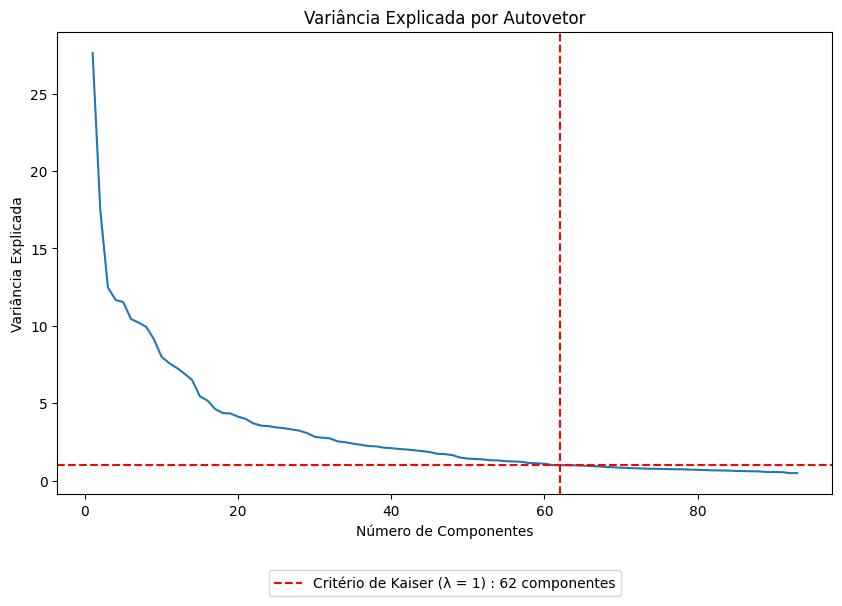

Número de componentes pelo critério de Kaiser: 62


In [75]:
pca = PCA()
X_train_pca = pca.fit_transform(X_treino_scaled)

# Variância Acumlada
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

# Análise Eigenvalues (Critério de Kaiser e Análise de Cotovelo)
eigenvalues = pca.explained_variance_

eigenvalues_kaiser = eigenvalues[eigenvalues > 1]
n_componentes_kaiser = len(eigenvalues_kaiser)

# Plotar até o dobro do número de componentes indicado pelo critério de Kaiser
n_componentes_kaiser_plot = int(n_componentes_kaiser * 1.5)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=eigenvalues[0:n_componentes_kaiser_plot])

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=f"Critério de Kaiser (λ = 1) : {n_componentes_kaiser} componentes"
)

plt.axhline(
    y=1,
    color="red",
    linestyle="--"
)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)
plt.title("Variância Explicada por Autovetor")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada")
plt.show()

print(f"Número de componentes pelo critério de Kaiser: {n_componentes_kaiser}")

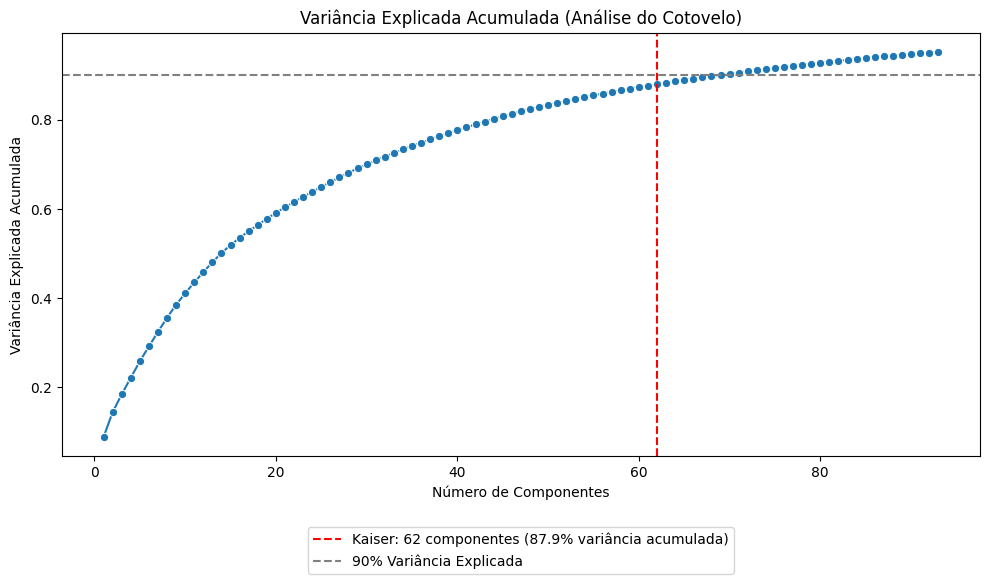

In [76]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=cum_var_exp[:n_componentes_kaiser_plot],
    marker='o'
)

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=(
        f"Kaiser: {n_componentes_kaiser} componentes "
        f"({cum_var_exp[n_componentes_kaiser - 1]:.1%} variância acumulada)"
    )
)

# Linha de referência (ex: 90%)
plt.axhline(
    y=0.9,
    color='gray',
    linestyle='--',
    label='90% Variância Explicada'
)

plt.title("Variância Explicada Acumulada (Análise do Cotovelo)")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)

plt.tight_layout()
plt.show()


Como parece não haver um "cotovelo" bem definido, vamos usar o critério de kaiser matendo aproxidamente 87,2% da variância acumulada com 62 PC´s

# Modelos com PCA

In [97]:

# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X_train_pca,
        y_treino,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)

Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7897
Desvio ROC_AUC: 0.0114
PR_AUC médio : 0.1412
Desvio PR_AUC: 0.0080
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.7670
Desvio ROC_AUC: 0.0097
PR_AUC médio : 0.1315
Desvio PR_AUC: 0.0097
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7587
Desvio ROC_AUC: 0.0115
PR_AUC médio : 0.1208
Desvio PR_AUC: 0.0084
--------------------------------------------------
